# Topic 11: Markov Models

## Reading: Bishop, Chapter 13

## IC11A Weather Prediction
Imagine that you're tasked with predicting the weather in a remote village, without access to the internet, no radar, etc.  In fact, let's imagine that the only thing that you have to go on is a long-term record of qualitative observations of the weather: sunny, raining, snowing.  

**It's raining today.  Using this dataset, create a 5 day forecast.  Specifically, report a probability that it will be sunny, rainy, or snowing for each of the next five days.**

In [2]:
import numpy as np
weather_data = np.load('weather.npy')

<img src="virga.jpg" />

## 1 Markov Models
One way of doing this, of course, would be just to come up with a naive statistical model.  In particular, we could model a given day's weather as a simple categorical distribution, with the probabilities derived from maximum likelihood estimation over the dataset.  
$$ P(W=w) = \begin{cases} \frac{m_{sun}}{m} &\text{if }w=\text{sunny} \\
                           \frac{m_{rain}}{m} &\text{if }w=\text{raining} \\
                           \frac{m_{snow}}{m} &\text{if }w=\text{snowy} \end{cases} $$

Of course, this model is going to be very poor.  **What assumption have we made that is probably invalid for the weather?**

A more reasonable way to proceed is to model weather as 
$$ P(W_t|W_{t-1},W_{t-2},\ldots) \neq P(W_t), $$
which is to say that *today's weather depends on yesterday's weather, and the day before, and the day before all the way back to the beginning of time*.  While this is a highly expressive model, it isn't practical.  **Why not?**.  

There is, of course, a middle ground.  We could condition our weather probability on a fixed and finite number of previous states.  In particular, when we condition exclusively on the previous state, we get something called a *first order Markov Model*, named after [Andrey Markov](https://en.wikipedia.org/wiki/Andrey_Markov), the Russian statistician.  A physical system where the future is independent of the past *given the present* is called a Markov process, or is said to be Markovian.  
$$
P(W_t|W_{t-1}) = P(W_t|W_{t-1},W_{t-2},\ldots)
$$
If we have a trained model, then we have the ability to answer the question: given that today is sunny, what is the probability that tomorrow will be rainy?  **What are the parameters of this model?  How many are there for the weather example?**

## IC11B Training a Markov Model
How should we train a Markov Model?  Training proceeds very much like in the case of the naive model: simply count the number of times that (e.g.) a sunny day transitioned to a rainy day, and divide by the total number of sunny days.  This is most easily done by creating a matrix $M$, where the *from* state is represented by the rows, and the *to* state by the columns, and the entry represents the total number of times that transition occurred:
$$
M = \begin{bmatrix} m_{\text{sun} \rightarrow \text{sun}} & m_{\text{sun} \rightarrow \text{rain}} &  m_{\text{sun} \rightarrow \text{snow}} \\
m_{\text{rain} \rightarrow \text{sun}} & m_{\text{rain} \rightarrow \text{rain}} &  m_{\text{rain} \rightarrow \text{snow}} \\
m_{\text{snow} \rightarrow \text{sun}} & m_{\text{snow} \rightarrow \text{rain}} &  m_{\text{snow} \rightarrow \text{snow}} 
\end{bmatrix},
                    $$
Once we've counted all the different transitions, we can create a matrix of transition probabilities (typically named $A$) by dividing each row in $M$ by the sum over that row.

**Compute the transition matrix $A$**.  

In [28]:
ha = {'sunny':0, 'raining':1, 'snowing':2}

M = np.zeros((3,3))
for i in range(1,len(weather_data)):
    M[ha[weather_data[i-1]],ha[weather_data[i]]] += 1
A = M/M.sum(axis=1)[:,np.newaxis]

In [29]:
print(A)
print(M)

[[0.79614325 0.20385675 0.        ]
 [0.33333333 0.45555556 0.21111111]
 [0.57575758 0.         0.42424242]]
[[578. 148.   0.]
 [ 90. 123.  57.]
 [ 57.   0.  42.]]


## 2 Generating Data
One interesting consequence of having explicitly formulated a probabilistic model of something is that we have the capacity to *simulate* new data.  So for example, once I have a trained $A$, I could simulate a weather record that is statistically consistent with the model by doing something like

In [30]:
### Comment me out to use the results from above!!!
#A = np.random.rand(3,3)
#A = A/(A.sum(axis=1)[:,np.newaxis])
###

current_state = 0 # Sunny
state_record = [current_state]
m_simulated = 100

# Create 100 synthetic observations
for i in range(m_simulated):
    # Extract the current state's row from the transition matrix
    transition_row = A[current_state]
    
    # Generate a new state by sampling from possible states with 
    # probability given by that row
    new_state = np.random.choice([0,1,2],p=transition_row)
    
    # Store and update the current state
    state_record.append(new_state)
    current_state=new_state


Alternatively, we can make *probabilistic* forecasts about what the weather will be.  This is especially simple for a Markov Model, as
$$
P(W_{t+1} | W_t) = A^T P(W_t)
$$
So for example, if we know for a fact that today is sunny, then $P(W_t) = [1,0,0]$, and we have that

In [33]:
weather_today = np.array([1,0,0])
forecast_tomorrow = A.T @ weather_today
print(forecast_tomorrow)

[0.79614325 0.20385675 0.        ]


Obviously, this just pulls the first row from the transition matrix, but we can chain these computations to get the weather after two days

In [34]:
forecast_twoday = A.T @ forecast_tomorrow
print(forecast_twoday)

[0.70179633 0.25516725 0.04303642]


In fact, we could come up with long term forecasts by repeated application of the transition matrix

In [36]:
weather_today = np.array([1,0,0])
forecasts = [weather_today]
days_to_forecast = 10
for t in range(days_to_forecast):
    forecast = A.T @ forecasts[-1]
    forecasts.append(forecast)

forecasts = np.array(forecasts).squeeze()

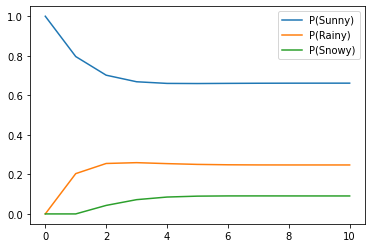

In [37]:
import matplotlib.pyplot as plt
plt.plot(forecasts[:,0],label='P(Sunny)')
plt.plot(forecasts[:,1],label='P(Rainy)')
plt.plot(forecasts[:,2],label='P(Snowy)')
plt.legend()
plt.show()

Interesting to note that repeated application yields a state probability that converges.  **What do you suppose the steady states for the probabilities are?  How could you check against your dataset?**

## 3 Markov Processes as a model for language
There are, of course, many other phenomena that could conceivably be modelled as a Markov Process (perhaps a higher-order Markov process).  Language is one example: the next word in a sentence is clearly dependent upon the word that immediately precedes it

Now, let's try a more interesting Markov model, in which we simulate the linguistic styles of various authors with recognizable styles.  To begin with, we'll train a Markov model with the complete works of William Shakespeare.  Much as in the weather example, training will consist of finding the transition probabilities from one word to the next.  As such, we'll compute prior probabilities representing the relative frequency of words in the body of work, and we'll also compute a gigantic set of transition probabilities from each word to all the other words.  First, we'll read in the Shakespeare text,

In [ ]:
from __future__ import division,print_function

import numpy as np
import string
from collections import Counter
import re
import json
import unicodedata

sequence_shakespeare = []
file = open('t8.shakespeare.txt','r')
for line in file:
    line.strip('\n')
    if line[:2] == '  ':
        line_words = re.findall(r"[\w']+|[.,!?;]",line)
        line_words = [str(w).lower() for w in line_words if not w.isupper() and not w.isdigit()] 

        sequence_shakespeare.extend(line_words)
        
print (' '.join(sequence_shakespeare[:100]))

He goes on an on.  Now, we'll create a First-order Markov Model built for this purpose

In [ ]:
class FirstOrderMarkovModel(object):
    """
    Implements a bigram model for text generation and classification

    Attributes:
        terminal_characters: a set of punctuation that shouldn't fall at the
                             beginning of a sentence, but should end one.

    Methods:
        build_transition_matrices: builds a dictionary of word frequency
        generate_phrase: generates a phrase by randomly sampling from 
                         word frequencies
        compute_log_likelihood: computes the logarithm of the likelihood
                                for a specified phrase

    """


    terminal_characters = ['.','?','!']

    def __init__(self,sequence):
        """
        sequence: an ordered list of words corresponding to the training set
        """

        self.order=1
        self.sequence = sequence
        self.sequence_length = len(sequence)
        self.transitions = [{}]
        for i in range(self.order):
            self.transitions.append({})
        

    def build_transition_matrices(self):
        """
        Builds a set of nested dictionaries of word probabilities
        """

        for i in range(self.sequence_length):
            word = self.sequence[i]
            if word in self.transitions[0]:
                self.transitions[0][word] += 1
            else:
                self.transitions[0][word] = 1

        transition_sum = float(sum(self.transitions[0].values()))
        for k,v in self.transitions[0].items():
            self.transitions[0][k] = v/transition_sum

        for i in range(self.sequence_length-1):
            word = self.sequence[i]
            next_word = self.sequence[i+1]
            if word in self.transitions[1]:
                if next_word in self.transitions[1][word]:
                    self.transitions[1][word][next_word] += 1
                else:
                    self.transitions[1][word][next_word] = 1
            else:
                self.transitions[1][word] = {}
                self.transitions[1][word][next_word] = 1

        for k_1,tdict in self.transitions[1].items():
            key_sum = float(sum(self.transitions[1][k_1].values()))
            for k_2,v in tdict.items():
                self.transitions[1][k_1][k_2] = v/key_sum 

    def generate_phrase(self):
        """
        Take a random sample from the probability distribution.  Terminate
        when a period, question mark, or exclamation point is drawn.
        """

        w_minus_1 = '?'
        while w_minus_1 in self.terminal_characters:
            w_minus_1 = np.random.choice([*self.transitions[0].keys()],replace=True,p=[*self.transitions[0].values()])
        phrase = w_minus_1+' '
        while w_minus_1 not in self.terminal_characters:
            w_minus_1 = np.random.choice([*self.transitions[1][w_minus_1].keys()],replace=True,p=[*self.transitions[1][w_minus_1].values()])
            phrase += w_minus_1+' '
        return phrase

    def compute_log_likelihood(self,phrase,lamda=0.0,unknown_probability=1e-5):
        """
        Return the log-probability of a given phrase (entered as a string)
        lambda: regularization factor for unseen transitions
        unknown_probability: probability mass of a word not in the dictionary.
        """

        words_in = phrase.split()
        
        w_i = words_in[0]
        try: 
            log_prob = np.log(self.transitions[0][w_i])
        except KeyError:
            log_prob = np.log(unknown_probability)
        for w in words_in[1:]:
            try:
                fjk = 0
                if w in self.transitions[1][w_i]:
                    fjk = self.transitions[1][w_i][w]
                log_prob += np.log((1-lamda)*fjk + lamda*self.transitions[0][w])
                w_i = w
            except KeyError:
                log_prob += np.log(unknown_probability)
        return log_prob

# Create First order Markov Model for shakespeare sequence
mm_shakespeare = FirstOrderMarkovModel(sequence_shakespeare)
mm_shakespeare.build_transition_matrices()

The last line has built the transition matrices, which are actually not matrices in this implementation, but instead dictionaries that store only entries for which there appears a transition.  For example, 'the' is never followed by another 'the', so it would be a waste to explicitly keep track of a zero probability case.  This is actually true for the vast majority of word pairs, so not keeping a 30000 by 30000 matrix is advantageous.  Let's take a look at these datastructures.

In [ ]:
mm_shakespeare.transitions[0]

sum([i for i in mm_shakespeare.transitions[0].values()])

This first dictionary is just the absolute word frequencies in the corpus: the probability of drawing a word from the shakespeare text, regardless of the preceding word.  These probabilities, of course, add up to one.

The second dictionary is more interesting.  It gives us the rows of a sparse transition matrix.  For example, what's the probability of transitioning from "cat" to any other word?

In [ ]:
mm_shakespeare.transitions[1]['cat']

With this model trained, we can do interesting things like generate a synthetic phrase, in exactly the same way that we did for the weather data.

In [ ]:
mm_shakespeare.generate_phrase()

The feel is right, if not exactly sensible!  These models are great at capturing tone and style, but not so much the meaning.  

Another thing that we can do is to use our statistical model to evaluate the probability of new examples.  For example, if I wanted to evaluate how probable it was that Shakespeare wrote the phrase

In [ ]:
test_string = 'to be or not to be'

I would just evaluate the prior probability on 'to' then multiply that by $P(be|to)$ then the probability of $P(or|be)$ and so on.  In practice we'll use log probabilities to avoid underflow:

In [ ]:
log_like_shakespeare = mm_shakespeare.compute_log_likelihood(test_string,lamda=0.01,unknown_probability=1e-10)
print (log_like_shakespeare)

These aren't that interesting on their own.  A better use for these log-likelihoods is as a classification scheme.  If I had another statistical model built upon a corpus of text, I could compute the likelihood for both and decide which writer produced the text.  **I posit that you've already done this.  What kind of model and dataset have we done something similar on in the past?**  

One contemporary goldmine of idiosyncratic text is the twitter account of Donald J. Trump.  Let us create a model for his tweets.  First, we read in the data

In [ ]:
sequence_trump = []
file = open('trump_tweets.json')
tweet_list = json.loads(file.read())
for t in tweet_list:
    tweet = unicodedata.normalize('NFKD',t['text'])
    tweet = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet)
    line_words = re.findall(r"[\w']+|[.,!?;]",tweet)
    line_words = [str(w).lower() for w in line_words if not w.isdigit()] 

    sequence_trump.extend(line_words)

print (' '.join(sequence_trump[:100]))


Like Shakespeare, he *also* goes on and on.  Now, we can use exactly the same code to generate the Trump Markov Model.

In [ ]:
mm_trump = FirstOrderMarkovModel(sequence_trump)
mm_trump.build_transition_matrices()

We can, again, generate a random phrase using this model:

In [ ]:
mm_trump.generate_phrase()

And now we can evaluate the likelihood of "to be or not to be" for Trump

In [ ]:
log_like_trump = mm_trump.compute_log_likelihood(test_string,lamda=0.01,unknown_probability=1e-10)

trump_factor = np.exp(log_like_trump - log_like_shakespeare)
print(trump_factor)

'to be or not to be' is 4 times more likely to be Shakespeare, which is not very strong evidence.  Let's try again with a longer phrase.

In [ ]:
test_string = 'to be or not to be , that is the question'
log_like_shakespeare = mm_shakespeare.compute_log_likelihood(test_string,lamda=0.01,unknown_probability=1e-10)
log_like_trump = mm_trump.compute_log_likelihood(test_string,lamda=0.01,unknown_probability=1e-10)

trump_factor = np.exp(log_like_trump - log_like_shakespeare)
print(trump_factor)

This is much more likely to be Shakespeare, now that we have more data.  Conversely, let's try something that Trump actually said, but was certainly not in the tweet corpus.

In [ ]:
test_string = """my uncle explained that to me many, many years ago, 
the power and that was 35 years ago; he would explain the power of what's 
going to happen and he was right—who would have thought?, but when you look 
at what's going on with the four prisoners—now it used to be three, 
now it’s four—but when it was three and even now, I would have said 
it's all in the messenger; fellas, and it is fellas because, you know, 
they don't, they haven’t figured that the women are smarter right now than the men, 
so, you know, it’s gonna take them about another 150 years—but the Persians are 
great negotiators, the Iranians are great negotiators, so, and they, they just killed, they just killed us."""

log_like_shakespeare = mm_shakespeare.compute_log_likelihood(test_string,lamda=0.01,unknown_probability=1e-10)
log_like_trump = mm_trump.compute_log_likelihood(test_string,lamda=0.01,unknown_probability=1e-10)

trump_factor = np.exp(log_like_trump - log_like_shakespeare)
print(trump_factor)

This is much more likely to have been written by Trump.

Finally, these models in which words are only dependent on their immediate predecessor are called 'bigram' models.  They aren't particularly good at generating realistic text.  Better results can be had by considering the previous two or more words, albeit with a commensurate increase in cost and tendency to overfit.  **Now, instead of having $\mathcal{O(v^2)}$, where $v$ is the size of the vocabulary, how many parameters will we have?**

In [ ]:
class SecondOrderMarkovModel(object):
    """
    Implements a trigram model for text generation

    Attributes:
        terminal_characters: a set of punctuation that shouldn't fall at the
                             beginning of a sentence, but should end one.

    Methods:
        build_transition_matrices: builds a dictionary of word frequency
        generate_phrase: generates a phrase by randomly sampling from 
                         word frequencies

    """


    terminal_characters = ['.','?','!']

    def __init__(self,sequence):
        """
        sequence: an ordered list of words corresponding to the training set
        """

        self.order=2
        self.sequence = sequence
        self.sequence_length = len(sequence)
        self.transitions = [{}]
        for i in range(self.order):
            self.transitions.append({})

    def build_transition_matrices(self):
        """
        Builds a set of nested dictionaries of word probabilities
        """

        for i in range(self.sequence_length):
            word = self.sequence[i]
            if word in self.transitions[0]:
                self.transitions[0][word] += 1
            else:
                self.transitions[0][word] = 1

        transition_sum = float(sum(self.transitions[0].values()))
        for k,v in self.transitions[0].items():
            self.transitions[0][k] = v/transition_sum

        for i in range(self.sequence_length-1):
            word = self.sequence[i]
            next_word = self.sequence[i+1]
            if word in self.transitions[1]:
                if next_word in self.transitions[1][word]:
                    self.transitions[1][word][next_word] += 1
                else:
                    self.transitions[1][word][next_word] = 1
            else:
                self.transitions[1][word] = {}
                self.transitions[1][word][next_word] = 1

        for k_1,tdict in self.transitions[1].items():
            key_sum = float(sum(self.transitions[1][k_1].values()))
            for k_2,v in tdict.items():
                self.transitions[1][k_1][k_2] = v/key_sum 

        for i in range(self.sequence_length-2):
            word = self.sequence[i]
            next_word = self.sequence[i+1]
            next_next_word = self.sequence[i+2]
            if word in self.transitions[2]:
                if next_word in self.transitions[2][word]:
                    if next_next_word in self.transitions[2][word][next_word]:
                        self.transitions[2][word][next_word][next_next_word] += 1
                    else:
                        self.transitions[2][word][next_word][next_next_word] = 1
                else:
                    self.transitions[2][word][next_word] = {}
                    self.transitions[2][word][next_word][next_next_word] = 1
            else:
                self.transitions[2][word] = {}
                self.transitions[2][word][next_word] = {}
                self.transitions[2][word][next_word][next_next_word] = 1
                    
        for k_1,tdict_1 in self.transitions[2].items():
            for k_2,tdict_2 in tdict_1.items():
                key_sum = float(sum(tdict_2.values()))
                for k_3,v in tdict_2.items():
                    self.transitions[2][k_1][k_2][k_3] = v/key_sum

    def generate_phrase(self):
        """
        Take a random sample from the probability distribution.  Terminate
        when a period, question mark, or exclamation point is drawn.
        """
        w_minus_2 = '?'
        while w_minus_2 in self.terminal_characters:
            w_minus_2 = np.random.choice([*self.transitions[0].keys()],replace=True,p=[*self.transitions[0].values()])
        w_minus_1 = np.random.choice([*self.transitions[1][w_minus_2].keys()],replace=True,p=[*self.transitions[1][w_minus_2].values()])
        phrase = w_minus_2 + ' ' + w_minus_1 + ' '
        while w_minus_1 not in self.terminal_characters:
            t_mat = self.transitions[2][w_minus_2][w_minus_1]
            w_i = np.random.choice([*t_mat.keys()],replace=True,p=[*t_mat.values()])
            phrase += w_i + ' '
            w_minus_2 = w_minus_1
            w_minus_1 = w_i
        return phrase



In [ ]:
mm_shakespeare = SecondOrderMarkovModel(sequence_shakespeare)
mm_shakespeare.build_transition_matrices()
mm_trump = SecondOrderMarkovModel(sequence_trump)
mm_trump.build_transition_matrices()

shakespeare_or_trump = ['Shakespeare','Trump']

We can use these to play a game: we'll randomly select from the two models, generate a phrase and try to decide who said it!

In [ ]:
models = [mm_shakespeare,mm_trump]
index = np.random.randint(2)
models[index].generate_phrase()

In [ ]:
print(index)

## In class exercise: Gene Sequence Clustering

### Training a Markov model
Load the file genes\_training.p, which is available in this homework archive.  genes\_training.p contains 2000 sequences, with each sequence $\mathbf{s}$ consisting of 20 nucleobases $s_i \in \mathrm{Nu},\; \mathrm{Nu} = \{A,T,G,C\}$.  Each of these sequences is generated from one of two separate Markov processes.  The label (aka class) of the process that generated the sequence is given in the dataset. 

Learn the Markov model for each class given the training data.  **To do this, for each class compute the prior probability $\mathbf{\pi}_c$ of each nucleobase (the relative frequency of each nucleobase for each class, a vector of length 4) and the matrix of transition probabilities** 
$$
\mathcal{A}_{c,kj} = P(s_{i+1}=\mathrm{Nu}_j|s_{i}=\mathrm{Nu}_k),
$$ 
which is a 4 by 4 matrix.  As a quick sanity check, each row of $\mathcal{A}_c$ should sum to one.  **Using these priors and transition matrices, write a function that generates a new sequence given the class**, i.e. simulates a data point. 

In [ ]:
import pickle
import numpy as np

# Define some useful constants
N_nucleobases = 4
N_classes = 2
nucleobases = ['A','T','G','C']

# Load the training data using pickle
sequences,labels = pickle.load(open('genes_training.p','rb'))

# Initialize the class priors and transition matrices
pi_0 = np.zeros((N_classes))
pi_1 = np.zeros((N_classes))

A_0 = np.zeros((N_nucleobases,N_nucleobases))
A_1 = np.zeros((N_nucleobases,N_nucleobases))

##### Train prior #####

#! Compute class priors

#! Compute unconditional nucleobase probabilities

# Convert from counts to probabilities by normalizing
pi_0/=pi_0.sum()
pi_1/=pi_1.sum()

##### Train transition matrix #####
for s,l in zip(sequences,labels):
    sequence_length = len(s)
    for p in range(sequence_length-1):
        #! s is a length 20 sequence of nucleoboases, for all s, count the number of times that a nucleobase 
        #! transitions to another nucleobase and record this information in the appropriate transition matrix (A_0 or A_1)
        pass
    
# Convert from counts to probabilities by row normalization
A_0/=A_0.sum(axis=1)[:,np.newaxis]
A_1/=A_1.sum(axis=1)[:,np.newaxis]

##### Generate a synthetic sequence #####
def generate_new_sequence(A,pi,n=20):
    """  
    Arguments:
    A -> Nucleobase transition matrix
    pi -> Prior
    n -> length of sequence to generate
    """
    # Draw from the prior for the first nucleobase
    s = [np.random.choice(nucleobases,pi)]
    #! Write the code that uses the transition matrix to produce a length n sample
    return s

### A Markov classifier
Having the prior and transition probabilities gives you the ability to evaluate the likelihood of a sequence for a given class as:
$$
P(\mathbf{s}) = P(s_1|\mathbf{\pi}_c) \prod_{i=1}^{n-1} P(s_{i+1}|s_{i},\mathcal{A}_c),
$$
where $\mathbf{\pi}_c$ is the class-conditioned prior probability, and $\mathcal{A}_c$ is the class-conditioned transition matrix.  Comparing the computed likelihood for a given sequence between different classes forms the basis of a classifier in a very similar manner to naive Bayes.  The difference this time is that now each random variable depends on the one before it in the sequence, whereas in naive Bayes we assumed that all the random variables were independent.    

Load the file genes\_test.p, which is similar to genes\_training.p.  **For each sequence, compute the likelihood for both classes and assign a label.  Compare this predicted label to the known one, and report the test set accuracy**.  As a point of comparison, my implementation achieved 98.7\% accuracy.

In [ ]:
sequences_test,labels_test = pickle.load(open('genes_test.p','rb'))
sequence_probabilities_0 = []
sequence_probabilities_1 = []

for s in sequences_test:
    #! Write a function that evaluates the probability of class membership for each class by multiplying the 
    #! prior by the likelihood over all symbol transitions

**Turn in a document with the names of those with whom you worked, an example sequence generated by your model for each class, and a statement of your classifier's overall accuracy.**